# Pratice 1.2 Quantum Neural Networks

MQIST 2025/26: Quantum Computing and Machine Learning

Alfredo Chavert Sancho

Pedro Herrero Maldonado

***
Cosas a probar:
- Cambiar número de qubits (más componentes en PCA)
- Cambiar número de capas del ansatz
- Cambiar feature map (ZZFeatureMap, PauliFeatureMap, etc)
- Cambiar optimizador: COBYLA, SPSA
***

## Data loading and preprocessing

The `load_breast_cancer` function from `sklearn.datasets` is used to load the breast cancer dataset. This dataset contains features computed from breast cancer biopsy images, along with labels indicating whether the cancer is malignant or benign. So this is a binary classification problem.

In [1]:
from sklearn.datasets import load_breast_cancer
data = load_breast_cancer()
X = data.data # features
y = data.target # labels

print("Original shape:", X.shape)

Original shape: (569, 30)


For the prepocessing the data to be used in the quantum neural network, we will use  ``StandardScaler`` from ``sklearn.preprocessing`` to normalize it  since all the data is numeric.

We will also use ``PCA`` from ``sklearn.decomposition`` to reduce the dimensionality of the data to reduce the number of qubits needed in the quantum neural network.

In [2]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Standardize (important for PCA)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply PCA (ex: reduce to 2 components for visualization or QML input)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

print("Shape after PCA:", X_pca.shape) # (150, 2)
print("Explained variance:", pca.explained_variance_ratio_)
print("Total variance explained:", pca.explained_variance_ratio_.sum())

Shape after PCA: (569, 2)
Explained variance: [0.44272026 0.18971182]
Total variance explained: 0.6324320765155946


- PC1 (0.44): The first dimension alone holds 44.3% of the information in your dataset. This is the single strongest pattern in the data (likely related to the overall size/magnitude of the tumor cells).

- PC2 (0.19): The second dimension adds another 19.0% of distinct information (likely related to the shape/irregularity of the cells).

Total (0.63): When you combine them, you are preserving 63.2% of the original data's structure. For visualization purposes, this is often sufficient to see meaningful patterns.

Visualize the data to be used in the quantum neural network. 

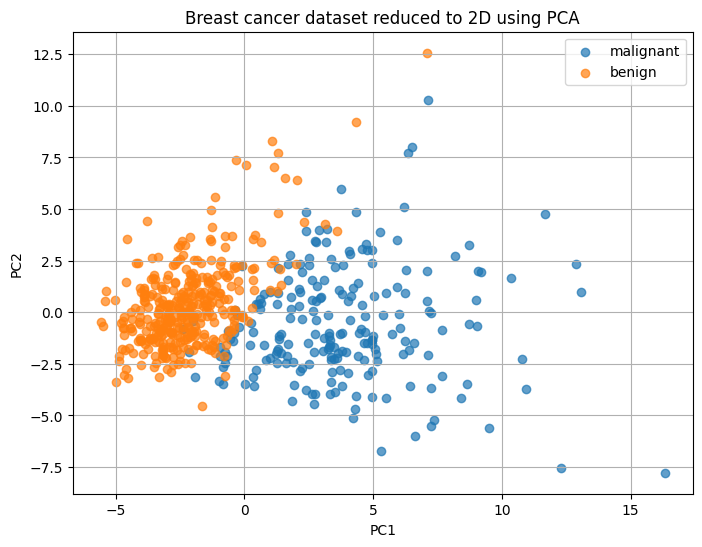

In [3]:
# Plot the result
plt.figure(figsize=(8,6))
for label in [0, 1]:
    plt.scatter(
                X_pca[y == label, 0],
                X_pca[y == label, 1],
                label=data.target_names[label],
                alpha=0.7
                )
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("Breast cancer dataset reduced to 2D using PCA")
plt.legend()
plt.grid(True)
plt.show()

As we see in the plot, the two classes (malignant and benign) are somewhat separable in this 2D PCA space, which is promising for classification tasks using a quantum neural network.

To ensure better total variance retention, we will consider enough principal components to capture at least 95% of the variance in the dataset.

In [4]:
# Apply PCA (to 2 components for QML input)
pca = PCA(n_components=4)
X_pca = pca.fit_transform(X_scaled)

print("Shape after PCA:", X_pca.shape) # (150, 2)
print("Explained variance:", pca.explained_variance_ratio_)
print("Total variance explained:", pca.explained_variance_ratio_.sum())

Shape after PCA: (569, 4)
Explained variance: [0.44272026 0.18971182 0.09393163 0.06602135]
Total variance explained: 0.7923850582446098


Next we will divide the data into train and test

In [5]:
from sklearn.model_selection import train_test_split
from qiskit_algorithms.utils import algorithm_globals

# Set the seed so results are reproducible
algorithm_globals.random_seed = 42

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
            X_pca, y, test_size=0.2, random_state=algorithm_globals.random_seed,
)

## Quantum neural network to predict class of each case

### Feature map

Lets choose a **Feature map** to represent the data in a quantum state

In [6]:
# Number of features after PCA
num_features = X_pca.shape[1]
print(f'The number of features after PCA is: {num_features}')

from qiskit.circuit.library import ZZFeatureMap, ZFeatureMap, PauliFeatureMap

'Choose a feature map to represent the data in a quantum state'
ZZ_feature_map = ZZFeatureMap(feature_dimension = num_features,
                              reps = 3,
                              entanglement = 'linear')

Z_feature_map = ZFeatureMap(feature_dimension = num_features,
                            reps = 3)

Pauli_feature_map = PauliFeatureMap(feature_dimension = num_features,
                                    reps = 3,
                                    paulis = ['ZZ', 'XX', 'YY'],
                                    entanglement = 'linear')

feature_map = Z_feature_map

The number of features after PCA is: 4


### Ansatz

Next, we will choose a **Variational form (ansatz)** for our quantum neural network

In [7]:
from qiskit.circuit.library import RealAmplitudes, TwoLocal, NLocal, EfficientSU2

'Choose a variational form (ansatz) for our quantum neural network'
real_amplitudes_ansatz = RealAmplitudes(num_qubits = num_features, 
                                        reps = 3, 
                                        name = 'RealAmplitudes')

two_local_ansatz = TwoLocal(num_qubits = num_features, 
                            rotation_blocks = 'ry', 
                            entanglement_blocks = 'cz', 
                            reps = 3, 
                            name = 'TwoLocal')

esu2_ansatz = EfficientSU2(num_qubits = num_features, 
                           entanglement = 'full', 
                           reps = 3, 
                           name = 'EfficientSU2')


ansatz = real_amplitudes_ansatz

### Optimizer

An **optimizer** is needed to minimize the loss function during the training of the quantum neural network. 

In [8]:
from qiskit_machine_learning.optimizers import COBYLA, SPSA, ADAM, GradientDescent


spsa_optimizer = SPSA(maxiter = 100)

adam_optimizer = ADAM(maxiter = 200)

cobyla_optimizer = COBYLA(maxiter = 200, 
                    disp = False, 
                    rhobeg = 1.0)

gd_optimizer = GradientDescent(maxiter = 100, 
                         learning_rate = 0.01, 
                         tol = 1e-07)

optimizer = cobyla_optimizer

### Variational Quantum Classifier

Finally let's build a Variational Quantum Classifier (VQC) using this feature map, ansatz and optimizer.

But first, we will define a callback function to visualize the training progress.

0.9266656658034981


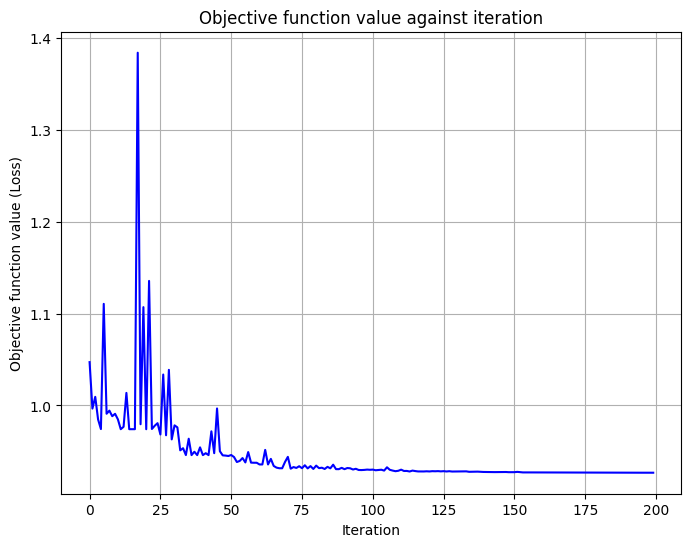

Training time: 223 seconds


In [9]:
import matplotlib.pyplot as plt
from qiskit_machine_learning.algorithms.classifiers import VQC
from IPython.display import clear_output 
import time

# Initialize the storage for the plot
objective_func_vals = []

# Define the callback
def callback_graph(_weights, _obj_func_eval):
    '''Callback function to visualize training progress
    
    Parameters:
        weights : Current parameters of the ansatz.
        obj_func_eval : Current loss value (error rate).
    '''
    
    clear_output(wait=True) # Clear previous output to update the plot
    print(_obj_func_eval)
    objective_func_vals.append(_obj_func_eval)
    
    plt.figure(figsize=(8,6))
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value (Loss)")
    plt.plot(range(len(objective_func_vals)), objective_func_vals, color='blue')
    plt.grid(True)
    plt.show()

vqc = VQC(
    feature_map = feature_map,
    ansatz = ansatz,
    optimizer = optimizer,
    callback = callback_graph)
start = time.time()

vqc.fit(X_train, y_train)

elapsed = time.time() - start
print(f"Training time: {round(elapsed)} seconds")

### Results for the VQC

In [10]:
from sklearn.metrics import recall_score, classification_report

train_score_q4 = vqc.score(X_train, y_train)
test_score_q4 = vqc.score(X_test, y_test)

y_pred = vqc.predict(X_test)
recall_q4 = recall_score(y_test, y_pred)
report_q4 = classification_report(y_test, y_pred)

print(f"Quantum VQC accuracy on the training dataset: {train_score_q4:.2f}")
print(f"Quantum VQC accuracy on the test dataset:     {test_score_q4:.2f}")
print(f"Quantum VQC recall on the test dataset:     {recall_q4:.2f}")
print(report_q4)

Quantum VQC accuracy on the training dataset: 0.63
Quantum VQC accuracy on the test dataset:     0.61
Quantum VQC recall on the test dataset:     0.96
              precision    recall  f1-score   support

           0       0.40      0.05      0.08        43
           1       0.62      0.96      0.76        71

    accuracy                           0.61       114
   macro avg       0.51      0.50      0.42       114
weighted avg       0.54      0.61      0.50       114



We can see that the accuracy is low (regarding our limited data representation due to the PCA), but the model doesn't present overfitting.

## Testing feature maps

First, we are going to test some typical feature maps for the VQC, with the same ansatz and optimizer, to better asses its performance.

### ZZ Feature Map

0.9516479918141939


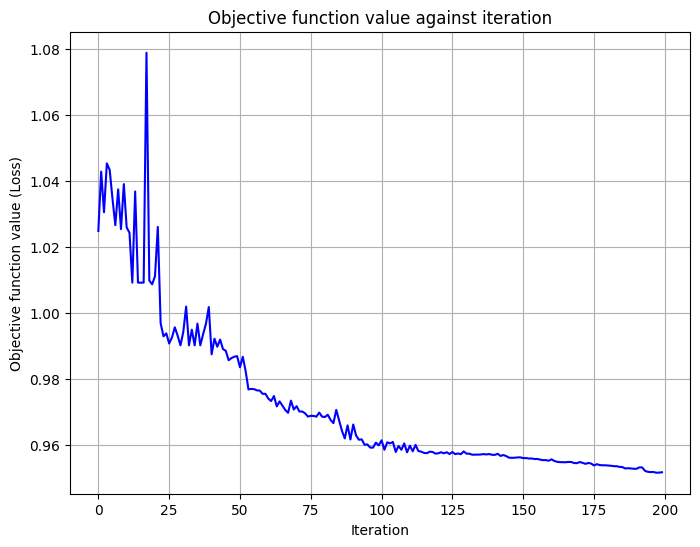

Training time: 313 seconds


In [12]:
ZZ_feature_map = ZZFeatureMap(feature_dimension = num_features,
                              reps = 3,
                              entanglement = 'linear')

real_amplitudes_ansatz = RealAmplitudes(num_qubits = num_features, reps = 3, name = 'RealAmplitudes')

cobyla_optimizer = COBYLA(maxiter = 200, 
                    disp = False, 
                    rhobeg = 1.0)

vqc_ZZ_RA_COBYLA = VQC(feature_map = ZZ_feature_map,
                       ansatz = real_amplitudes_ansatz,
                       optimizer = cobyla_optimizer,
                       callback = callback_graph)
start = time.time()

objective_func_vals = []
vqc_ZZ_RA_COBYLA.fit(X_train, y_train)

elapsed = time.time() - start
print(f"Training time: {round(elapsed)} seconds")

In [13]:
train_score_ZZ_RA_COBYLA = vqc_ZZ_RA_COBYLA.score(X_train, y_train)
test_score_ZZ_RA_COBYLA = vqc_ZZ_RA_COBYLA.score(X_test, y_test)

y_pred_ZZ_RA_COBYLA = vqc_ZZ_RA_COBYLA.predict(X_test)
recall_ZZ_RA_COBYLA = recall_score(y_test, y_pred_ZZ_RA_COBYLA)
report_ZZ_RA_COBYLA = classification_report(y_test, y_pred_ZZ_RA_COBYLA)

print(f"ZZ Feature map accuracy on the training dataset: {train_score_ZZ_RA_COBYLA:.2f}")
print(f"ZZ Feature map accuracy on the test dataset:     {test_score_ZZ_RA_COBYLA:.2f}")
print(f"Quantum VQC recall on the test dataset:     {recall_ZZ_RA_COBYLA:.2f}")
print(report_ZZ_RA_COBYLA)

ZZ Feature map accuracy on the training dataset: 0.60
ZZ Feature map accuracy on the test dataset:     0.56
Quantum VQC recall on the test dataset:     0.75
              precision    recall  f1-score   support

           0       0.38      0.26      0.31        43
           1       0.62      0.75      0.68        71

    accuracy                           0.56       114
   macro avg       0.50      0.50      0.49       114
weighted avg       0.53      0.56      0.54       114



### Pauli Feature Map

0.9284973151897875


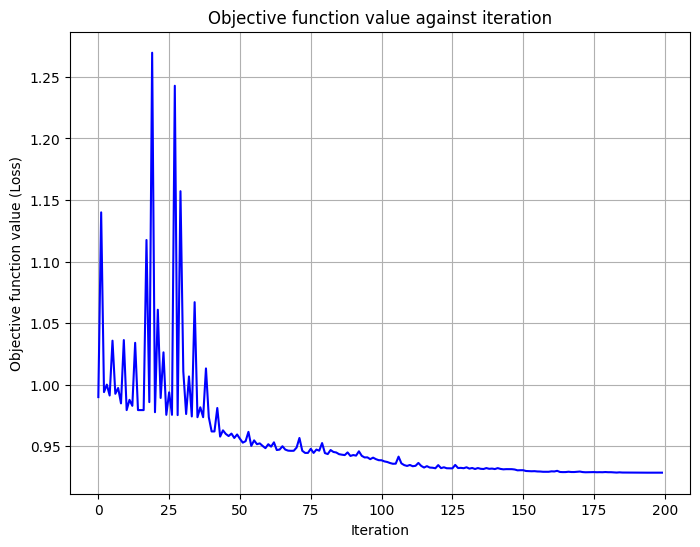

Training time: 594 seconds


In [14]:
Pauli_feature_map = PauliFeatureMap(feature_dimension = num_features,
                                    reps = 3,
                                    paulis = ['ZZ', 'XX', 'YY'],
                                    entanglement = 'linear')

real_amplitudes_ansatz = RealAmplitudes(num_qubits = num_features, reps = 3, name = 'RealAmplitudes')

cobyla_optimizer = COBYLA(maxiter = 200, 
                    disp = False, 
                    rhobeg = 1.0)

vqc_Pauli_RA_COBYLA = VQC(feature_map = Pauli_feature_map,
                       ansatz = real_amplitudes_ansatz,
                       optimizer = cobyla_optimizer,
                       callback = callback_graph)
start = time.time()

objective_func_vals = []
vqc_Pauli_RA_COBYLA.fit(X_train, y_train)

elapsed = time.time() - start
print(f"Training time: {round(elapsed)} seconds")

In [15]:
train_score_Pauli_RA_COBYLA = vqc_Pauli_RA_COBYLA.score(X_train, y_train)
test_score_Pauli_RA_COBYLA = vqc_Pauli_RA_COBYLA.score(X_test, y_test)

y_pred_Pauli_RA_COBYLA = vqc_Pauli_RA_COBYLA.predict(X_test)
recall_Pauli_RA_COBYLA = recall_score(y_test, y_pred_Pauli_RA_COBYLA)
report_Pauli_RA_COBYLA = classification_report(y_test, y_pred_Pauli_RA_COBYLA)

print(f"Pauli Feature map accuracy on the training dataset: {train_score_Pauli_RA_COBYLA:.2f}")
print(f"Pauli Feature map accuracy on the test dataset:     {test_score_Pauli_RA_COBYLA:.2f}")
print(f"Quantum VQC recall on the test dataset:     {recall_Pauli_RA_COBYLA:.2f}")
print(report_Pauli_RA_COBYLA)

Pauli Feature map accuracy on the training dataset: 0.63
Pauli Feature map accuracy on the test dataset:     0.60
Quantum VQC recall on the test dataset:     0.89
              precision    recall  f1-score   support

           0       0.38      0.12      0.18        43
           1       0.62      0.89      0.73        71

    accuracy                           0.60       114
   macro avg       0.50      0.50      0.46       114
weighted avg       0.53      0.60      0.52       114



## Testing Ansatzs

### Two Local Ansatz

0.9379728870045182


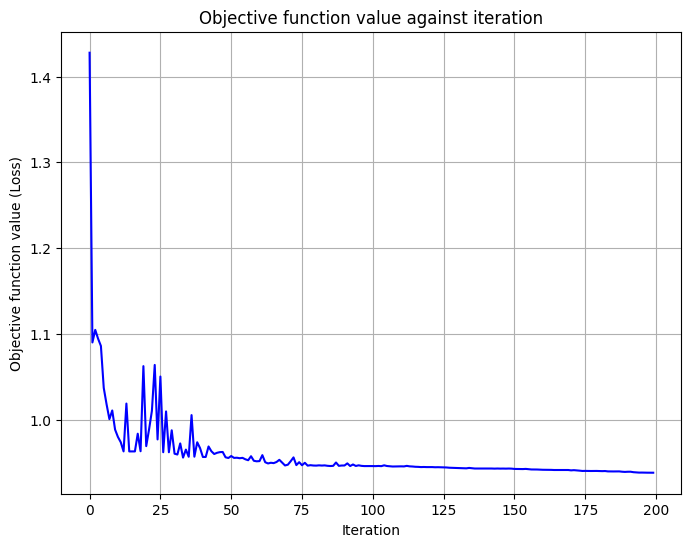

Training time: 243 seconds


In [16]:
Z_feature_map = ZFeatureMap(feature_dimension = num_features,
                            reps = 3)

two_local_ansatz = TwoLocal(num_qubits = num_features, 
                            rotation_blocks = 'ry', 
                            entanglement_blocks = 'cz', 
                            reps = 3, 
                            name = 'TwoLocal')

cobyla_optimizer = COBYLA(maxiter = 200, 
                    disp = False, 
                    rhobeg = 1.0)

vqc_Z_2L_COBYLA = VQC(feature_map = Z_feature_map,
                       ansatz = two_local_ansatz,
                       optimizer = cobyla_optimizer,
                       callback = callback_graph)
start = time.time()


objective_func_vals = []
vqc_Z_2L_COBYLA.fit(X_train, y_train)

elapsed = time.time() - start
print(f"Training time: {round(elapsed)} seconds")

In [17]:
train_score_Z_2L_COBYLA = vqc_Z_2L_COBYLA.score(X_train, y_train)
test_score_Z_2L_COBYLA = vqc_Z_2L_COBYLA.score(X_test, y_test)

y_pred_Z_2L_COBYLA = vqc_Z_2L_COBYLA.predict(X_test)
recall_Z_2L_COBYLA = recall_score(y_test, y_pred_Z_2L_COBYLA)
report_Z_2L_COBYLA = classification_report(y_test, y_pred_Z_2L_COBYLA)

print(f"Two local ansatz accuracy on the training dataset: {train_score_Z_2L_COBYLA:.2f}")
print(f"Two local ansatz accuracy on the test dataset:     {test_score_Z_2L_COBYLA:.2f}")
print(f"Quantum VQC recall on the test dataset:     {recall_Z_2L_COBYLA:.2f}")
print(report_Z_2L_COBYLA)

Two local ansatz accuracy on the training dataset: 0.63
Two local ansatz accuracy on the test dataset:     0.61
Quantum VQC recall on the test dataset:     0.97
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        43
           1       0.62      0.97      0.75        71

    accuracy                           0.61       114
   macro avg       0.31      0.49      0.38       114
weighted avg       0.38      0.61      0.47       114



### ESU2 Ansatz

0.9283124913690965


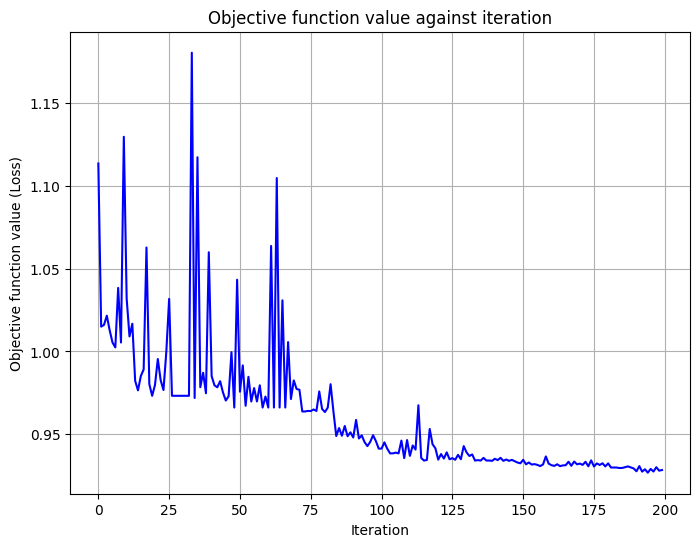

Training time: 307 seconds


In [18]:
Z_feature_map = ZFeatureMap(feature_dimension = num_features,
                            reps = 3)

esu2_ansatz = EfficientSU2(num_qubits = num_features, 
                           entanglement = 'full', 
                           reps = 3, 
                           name = 'EfficientSU2')

cobyla_optimizer = COBYLA(maxiter = 200, 
                    disp = False, 
                    rhobeg = 1.0)

vqc_Z_ESU2_COBYLA = VQC(feature_map = Z_feature_map,
                       ansatz = esu2_ansatz,
                       optimizer = cobyla_optimizer,
                       callback = callback_graph)
start = time.time()


objective_func_vals = []
vqc_Z_ESU2_COBYLA.fit(X_train, y_train)

elapsed = time.time() - start
print(f"Training time: {round(elapsed)} seconds")

In [19]:
train_score_Z_ESU2_COBYLA = vqc_Z_ESU2_COBYLA.score(X_train, y_train)
test_score_Z_ESU2_COBYLA = vqc_Z_ESU2_COBYLA.score(X_test, y_test)

y_pred_Z_ESU2_COBYLA  = vqc_Z_ESU2_COBYLA.predict(X_test)
recall_Z_ESU2_COBYLA  = recall_score(y_test, y_pred_Z_ESU2_COBYLA )
report_Z_ESU2_COBYLA = classification_report(y_test, y_pred_Z_ESU2_COBYLA)

print(f"ESU2 ansatz accuracy on the training dataset: {train_score_Z_ESU2_COBYLA:.2f}")
print(f"ESU2 ansatz accuracy on the test dataset:     {test_score_Z_ESU2_COBYLA:.2f}")
print(f"Quantum VQC recall on the test dataset:     {recall_Z_ESU2_COBYLA:.2f}")
print(report_Z_ESU2_COBYLA)

ESU2 ansatz accuracy on the training dataset: 0.64
ESU2 ansatz accuracy on the test dataset:     0.58
Quantum VQC recall on the test dataset:     0.87
              precision    recall  f1-score   support

           0       0.31      0.09      0.14        43
           1       0.61      0.87      0.72        71

    accuracy                           0.58       114
   macro avg       0.46      0.48      0.43       114
weighted avg       0.50      0.58      0.50       114



## Testing Optimizers

### SPSA Optimizer

In [21]:
Z_feature_map = ZFeatureMap(feature_dimension = num_features,
                            reps = 3)

real_amplitudes_ansatz = RealAmplitudes(num_qubits = num_features, 
                                        reps = 3, 
                                        name = 'RealAmplitudes')

spsa_optimizer = SPSA(maxiter = 100)

vqc_Z_RA_SPSA = VQC(feature_map = Z_feature_map,
                       ansatz = real_amplitudes_ansatz,
                       optimizer = spsa_optimizer)
start = time.time()


objective_func_vals = []
vqc_Z_RA_SPSA.fit(X_train, y_train)

elapsed = time.time() - start
print(f"Training time: {round(elapsed)} seconds")

Training time: 271 seconds


In [22]:
train_score_Z_RA_SPSA = vqc_Z_RA_SPSA.score(X_train, y_train)
test_score_Z_RA_SPSA = vqc_Z_RA_SPSA.score(X_test, y_test)

y_pred_Z_RA_SPSA  = vqc.predict(X_test)
recall_Z_RA_SPSA  = recall_score(y_test, y_pred_Z_RA_SPSA )
report_Z_RA_SPSA = classification_report(y_test, y_pred_Z_RA_SPSA)

print(f"SPSA optimizer accuracy on the training dataset: {train_score_Z_RA_SPSA:.2f}")
print(f"SPSA optimizer accuracy on the test dataset:     {test_score_Z_RA_SPSA:.2f}")
print(f"Quantum VQC recall on the test dataset:     {recall_Z_RA_SPSA:.2f}")
print(report_Z_RA_SPSA)

SPSA optimizer accuracy on the training dataset: 0.64
SPSA optimizer accuracy on the test dataset:     0.61
Quantum VQC recall on the test dataset:     0.96
              precision    recall  f1-score   support

           0       0.40      0.05      0.08        43
           1       0.62      0.96      0.76        71

    accuracy                           0.61       114
   macro avg       0.51      0.50      0.42       114
weighted avg       0.54      0.61      0.50       114



# Changing paameters on the best performing problem

## More epochs

0.9288527509170501


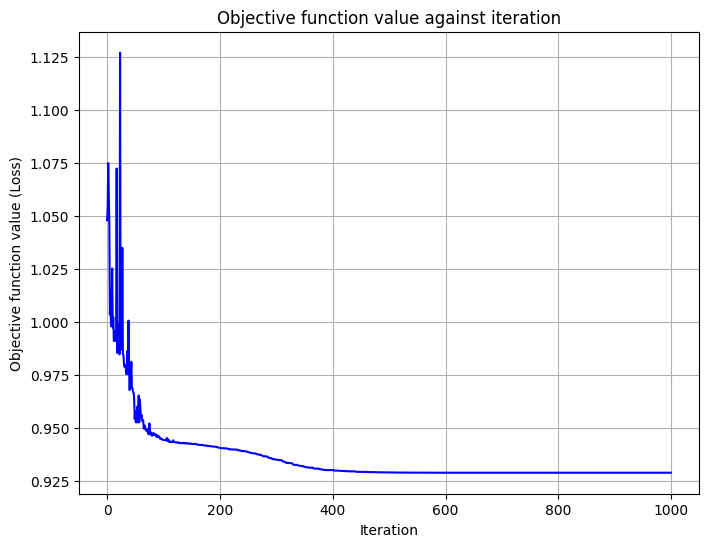

Training time: 1432 seconds


In [29]:
ZZ_feature_map = ZZFeatureMap(feature_dimension = num_features,
                              reps = 3,
                              entanglement = 'linear')

real_amplitudes_ansatz = RealAmplitudes(num_qubits = num_features, reps = 3, name = 'RealAmplitudes')

cobyla_optimizer = COBYLA(maxiter = 1000, 
                    disp = False,
                    tol = 1e-5,
                    rhobeg = 1.0)

vqc_best = VQC(feature_map = ZZ_feature_map,
                  ansatz = real_amplitudes_ansatz,
                  optimizer = cobyla_optimizer,
                  callback = callback_graph)
start = time.time()

objective_func_vals = []
vqc_best.fit(X_train, y_train)

elapsed = time.time() - start
print(f"Training time: {round(elapsed)} seconds")

In [30]:
train_score_best = vqc_best.score(X_train, y_train)
test_score_best = vqc_best.score(X_test, y_test)

y_pred_best  = vqc_best.predict(X_test)
recall_best  = recall_score(y_test, y_pred_best )
report_best = classification_report(y_test, y_pred_best)

print(f"Best model accuracy on the training dataset: {train_score_best:.2f}")
print(f"Best model accuracy on the test dataset:     {test_score_best:.2f}")
print(f"Best model recall on the test dataset:     {recall_best:.2f}")
print(report_best)

Best model accuracy on the training dataset: 0.62
Best model accuracy on the test dataset:     0.59
Best model recall on the test dataset:     0.85
              precision    recall  f1-score   support

           0       0.39      0.16      0.23        43
           1       0.62      0.85      0.72        71

    accuracy                           0.59       114
   macro avg       0.51      0.50      0.47       114
weighted avg       0.54      0.59      0.53       114



## More entanglement

0.92947886101527


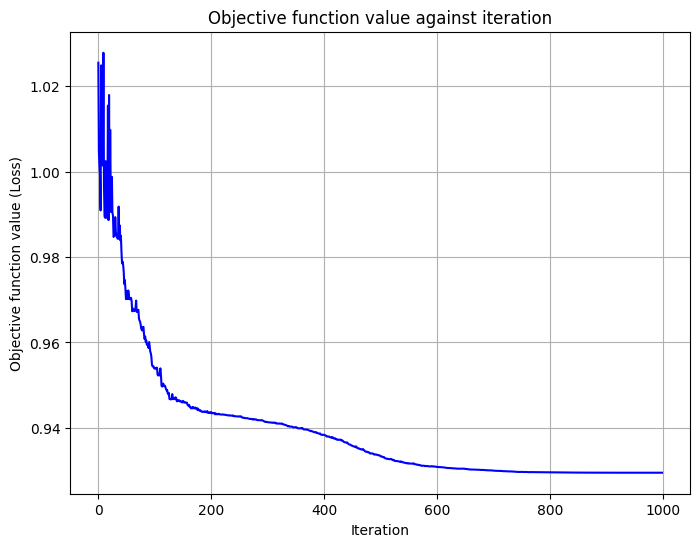

Training time: 1804 seconds


In [31]:
ZZ_feature_map = ZZFeatureMap(feature_dimension = num_features,
                              reps = 3,
                              entanglement = 'full')

real_amplitudes_ansatz = RealAmplitudes(num_qubits = num_features, 
                                        reps = 3, 
                                        name = 'RealAmplitudes')

cobyla_optimizer = COBYLA(maxiter = 1000, 
                    disp = False,
                    tol = 1e-5,
                    rhobeg = 1.0)

vqc_best2 = VQC(feature_map = ZZ_feature_map,
                  ansatz = real_amplitudes_ansatz,
                  optimizer = cobyla_optimizer,
                  callback = callback_graph)
start = time.time()

objective_func_vals = []
vqc_best2.fit(X_train, y_train)

elapsed = time.time() - start
print(f"Training time: {round(elapsed)} seconds")

In [32]:
y_pred_best2  = vqc_best2.predict(X_test)
report_best2 = classification_report(y_test, y_pred_best2)
print(report_best2)

              precision    recall  f1-score   support

           0       0.34      0.33      0.33        43
           1       0.60      0.62      0.61        71

    accuracy                           0.51       114
   macro avg       0.47      0.47      0.47       114
weighted avg       0.50      0.51      0.51       114



## More feature map reps

0.9535550736993287


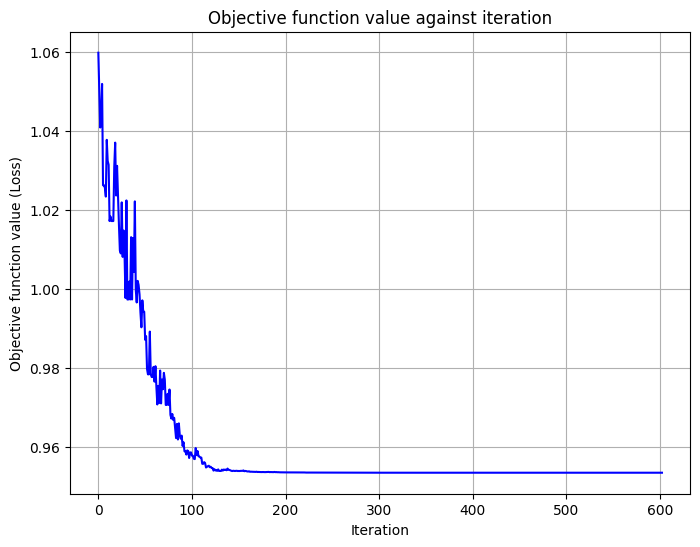

Training time: 1532 seconds


In [33]:
ZZ_feature_map = ZZFeatureMap(feature_dimension = num_features,
                              reps = 5,
                              entanglement = 'full')

real_amplitudes_ansatz = RealAmplitudes(num_qubits = num_features, 
                                        reps = 3, 
                                        name = 'RealAmplitudes')

cobyla_optimizer = COBYLA(maxiter = 1000, 
                    disp = False,
                    tol = 1e-5,
                    rhobeg = 1.0)

vqc_best3 = VQC(feature_map = ZZ_feature_map,
                  ansatz = real_amplitudes_ansatz,
                  optimizer = cobyla_optimizer,
                  callback = callback_graph)
start = time.time()

objective_func_vals = []
vqc_best3.fit(X_train, y_train)

elapsed = time.time() - start
print(f"Training time: {round(elapsed)} seconds")

In [34]:
y_pred_best3  = vqc_best3.predict(X_test)
report_best3 = classification_report(y_test, y_pred_best3)
print(report_best3)

              precision    recall  f1-score   support

           0       0.33      0.37      0.35        43
           1       0.59      0.55      0.57        71

    accuracy                           0.48       114
   macro avg       0.46      0.46      0.46       114
weighted avg       0.49      0.48      0.49       114



## More ansatz reps

0.9407346569594558


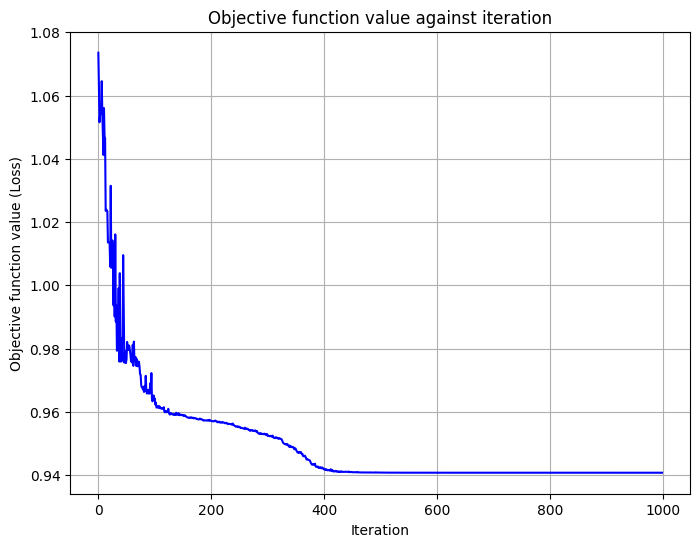

Training time: 2626 seconds


In [35]:
ZZ_feature_map = ZZFeatureMap(feature_dimension = num_features,
                              reps = 5,
                              entanglement = 'full')

real_amplitudes_ansatz = RealAmplitudes(num_qubits = num_features, 
                                        reps = 4, 
                                        name = 'RealAmplitudes')

cobyla_optimizer = COBYLA(maxiter = 1000, 
                    disp = False,
                    tol = 1e-5,
                    rhobeg = 1.0)

vqc_best4 = VQC(feature_map = ZZ_feature_map,
                  ansatz = real_amplitudes_ansatz,
                  optimizer = cobyla_optimizer,
                  callback = callback_graph)
start = time.time()

objective_func_vals = []
vqc_best4.fit(X_train, y_train)

elapsed = time.time() - start
print(f"Training time: {round(elapsed)} seconds")

In [37]:
y_pred_best4  = vqc_best4.predict(X_test)
report_best4 = classification_report(y_test, y_pred_best4)
print(report_best4)

              precision    recall  f1-score   support

           0       0.33      0.33      0.33        43
           1       0.60      0.61      0.60        71

    accuracy                           0.50       114
   macro avg       0.47      0.47      0.47       114
weighted avg       0.50      0.50      0.50       114



## More PCA components for the best performing model

In [6]:
pca = PCA(n_components=7)
X_pca = pca.fit_transform(X_scaled)

print("Shape after PCA:", X_pca.shape) # (150, 2)
print("Explained variance:", pca.explained_variance_ratio_)
print("Total variance explained:", pca.explained_variance_ratio_.sum())

Shape after PCA: (569, 7)
Explained variance: [0.44272026 0.18971182 0.09393163 0.06602135 0.05495768 0.04024522
 0.02250734]
Total variance explained: 0.9100953006967311


In [7]:
algorithm_globals.random_seed = 42

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_pca, 
                                                    y, 
                                                    test_size = 0.2, 
                                                    random_state = algorithm_globals.random_seed)

In [11]:
def callback_graph(_weights, _obj_func_eval):
    '''Callback function to visualize training progress
    
    Parameters:
        weights : Current parameters of the ansatz.
        obj_func_eval : Current loss value (error rate).
    '''
    
    clear_output(wait=True) # Clear previous output to update the plot
    print(_obj_func_eval)
    objective_func_vals.append(_obj_func_eval)
    
    plt.figure(figsize=(8,6))
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value (Loss)")
    plt.plot(range(len(objective_func_vals)), objective_func_vals, color='blue')
    plt.grid(True)
    plt.show()


0.95664049973259


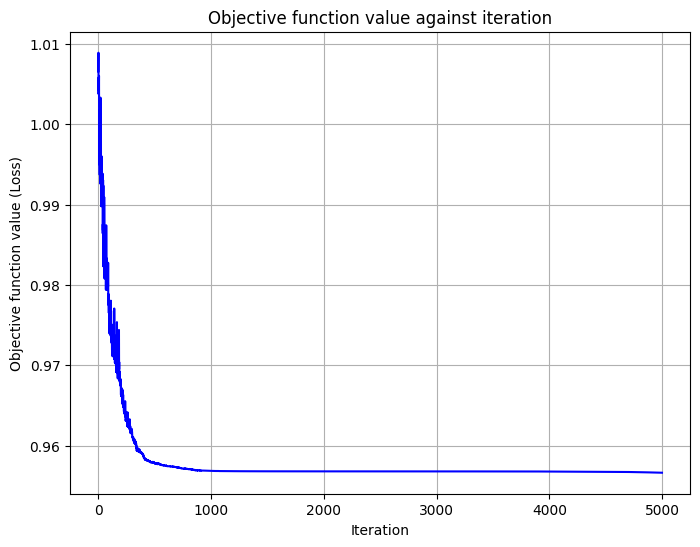

Training time: 39580 seconds


In [13]:
from qiskit.circuit.library import RealAmplitudes, ZZFeatureMap
from qiskit_machine_learning.optimizers import COBYLA
from sklearn.metrics import recall_score, classification_report
from qiskit_machine_learning.algorithms.classifiers import VQC
from IPython.display import clear_output 
import time

num_features = X_pca.shape[1]
ZZ_feature_map = ZZFeatureMap(feature_dimension = num_features,
                              reps = 5,
                              entanglement = 'full')

real_amplitudes_ansatz = RealAmplitudes(num_qubits = num_features, 
                                        reps = 4, 
                                        name = 'RealAmplitudes')

cobyla_optimizer = COBYLA(maxiter = 5000, 
                    disp = False,
                    tol = 1e-5,
                    rhobeg = 1.0)

vqc_best4 = VQC(feature_map = ZZ_feature_map,
                  ansatz = real_amplitudes_ansatz,
                  optimizer = cobyla_optimizer,
                  callback = callback_graph)
start = time.time()

objective_func_vals = []
vqc_best4.fit(X_train, y_train)

elapsed = time.time() - start
print(f"Training time: {round(elapsed)} seconds")

In [14]:
y_pred_best4  = vqc_best4.predict(X_test)
report_best4 = classification_report(y_test, y_pred_best4)
print(report_best4)

              precision    recall  f1-score   support

           0       0.40      0.51      0.45        43
           1       0.64      0.54      0.58        71

    accuracy                           0.53       114
   macro avg       0.52      0.52      0.52       114
weighted avg       0.55      0.53      0.53       114



In [15]:
vqc_best4.save('big_model.keras')